In [1]:
#Importing google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Importing required libraries
from tensorflow.keras.layers import  Dense, Dropout,  Input, Reshape, Conv1D, Activation,BatchNormalization, MaxPooling1D,LSTM
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad, SGD
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.utils import to_categorical, plot_model
import scipy.io
from scipy import signal
import glob
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import seaborn as sns

In [3]:
#Loading data
trainname='DL_32_8_result'
truename='DL_32_8_result_true'
train_raw=pd.read_csv('/content/drive/MyDrive/RAship/'+trainname+'.csv',header=None)
true=pd.read_csv('/content/drive/MyDrive/RAship/'+truename+'.csv',header=None)

#For bidmc
# true=true.drop(true.index[0])
del train_raw[0]
train_raw_fu=train_raw.drop(train_raw.index[0])
del true[0]
true=true.drop(true.index[0])
train_raw=train_raw.drop(train_raw.index[0])

train_raw=np.array(train_raw)
true=np.array(true)

print("Shape of training data with windows=",train_raw.shape)
print("Shape of true data with windows=",true.shape)

Shape of training data with windows= (3120, 4002)
Shape of true data with windows= (3120, 1)


In [4]:
#Declaring the variables
BATCH_SIZE=25
EPOCHS=100
BASE_DIR='/content/drive/MyDrive/RAship/M_weights'
INPUT_SHAPE=train_raw.shape[1]

In [5]:
    #Function to determine breathing rate
    #Input: 1xtrain_raw.shape[1](1002)- window from the training set
    #Output: 1x1 - Breating rate
    def Core_net():    

      i=Input(shape=(INPUT_SHAPE,1),name="input")
      m=Conv1D(32,kernel_size=40)(i)
      m=BatchNormalization()(m)
      m=Activation('relu')(m)
      m=MaxPooling1D(pool_size=4)(m)
      m=Dropout(0.1)(m)
      m=Conv1D(32,kernel_size=40)(m)
      m=BatchNormalization()(m)
      m=Activation('relu')(m)
      m=MaxPooling1D(pool_size=4)(m)
      m=Dropout(0.1)(m)
      m=LSTM(128, activation='tanh',return_sequences=True)(m)
      m=LSTM(128, activation='tanh')(m)
      m=Dense(1)(m)
      newmodel = Model(inputs=i,outputs=m)
      return newmodel

In [6]:
corenet=Core_net()
corenet.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 4002, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 3963, 32)          1312      
_________________________________________________________________
batch_normalization (BatchNo (None, 3963, 32)          128       
_________________________________________________________________
activation (Activation)      (None, 3963, 32)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 990, 32)           0         
_________________________________________________________________
dropout (Dropout)            (None, 990, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 951, 32)           40992 

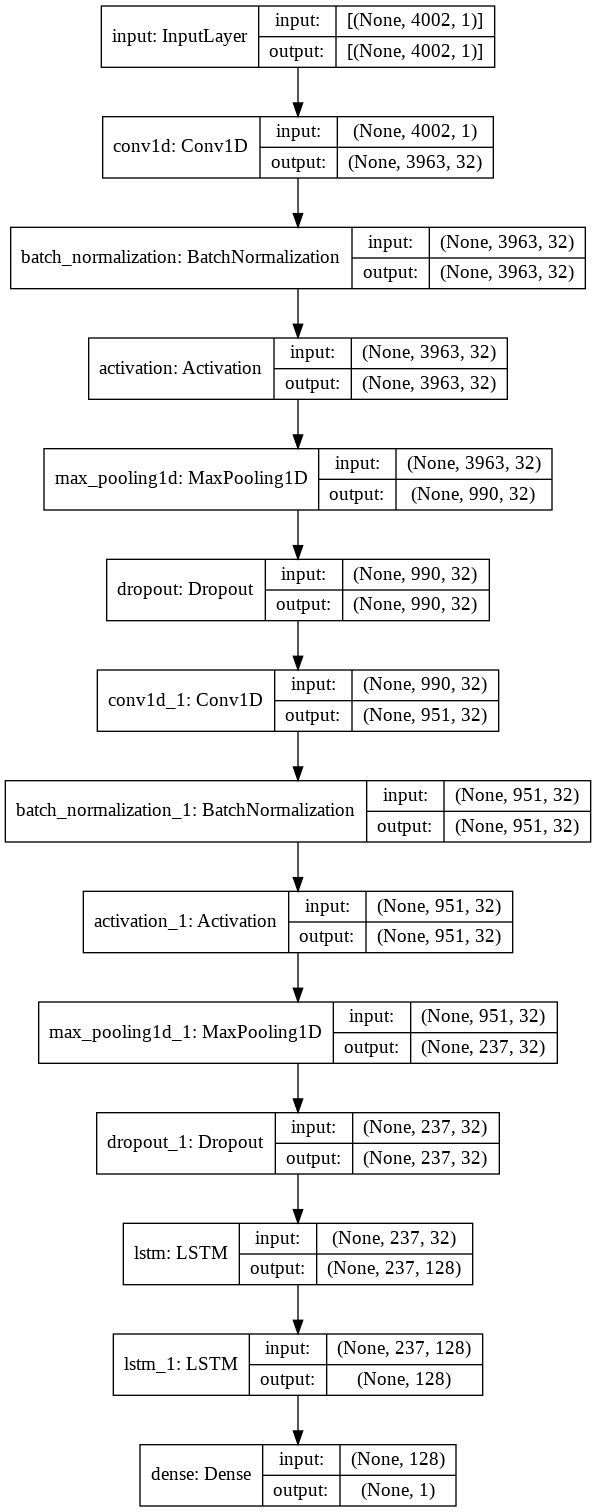

In [7]:

plot_model(corenet,show_shapes=True)

In [8]:
# Callback for saving model weights and log training results
def get_callbacks(name_weights):
    mcp_save = ModelCheckpoint(name_weights+"_weights.hdf5", save_best_only=True, monitor='val_loss', mode='min')
    csv_log=CSVLogger(name_weights+'.csv',separator=',')
    return [mcp_save, csv_log]

In [9]:
#Splitting the training data into train and test
PPG_train, PPG_test, PPG_true_train, PPG_true_test=train_test_split(train_raw,true,test_size=0.32,random_state=42)


In [10]:
gen_corenet=Core_net()
change="complete"
gen_corenet.compile(optimizer='RMSprop', loss='mean_absolute_error', metrics=['mse','mape'])
weight_dir=BASE_DIR+'/GenModel/'+trainname
if not os.path.exists(weight_dir):
    os.mkdir(weight_dir)
name_weights = weight_dir+"/GenModel"+change

In [11]:
callbacks = get_callbacks(name_weights)
# history=gen_corenet.fit(PPG_train,PPG_true_train, batch_size=25,epochs=EPOCHS,verbose=1,validation_data=(PPG_test,PPG_true_test),callbacks=callbacks,use_multiprocessing=False)
history=gen_corenet.fit(PPG_train,PPG_true_train, batch_size=BATCH_SIZE,epochs=EPOCHS,verbose=1,callbacks=callbacks)

Epoch 1/100
85/85 [==============================] - 72s 793ms/step - loss: 5.5619 - mse: 58.5521 - mape: 18436270.1390
Epoch 2/100
85/85 [==============================] - 66s 771ms/step - loss: 2.1645 - mse: 8.9766 - mape: 31187162.8394
Epoch 3/100
85/85 [==============================] - 82s 966ms/step - loss: 2.1536 - mse: 8.7556 - mape: 29936606.0170
Epoch 4/100
85/85 [==============================] - 67s 790ms/step - loss: 2.0799 - mse: 8.1658 - mape: 23826312.7712
Epoch 5/100
85/85 [==============================] - 68s 801ms/step - loss: 2.1529 - mse: 8.6614 - mape: 28051957.2217
Epoch 6/100
85/85 [==============================] - 66s 780ms/step - loss: 2.0372 - mse: 8.2194 - mape: 35199854.8333
Epoch 7/100
85/85 [==============================] - 68s 795ms/step - loss: 1.9953 - mse: 7.9495 - mape: 31362191.1586
Epoch 8/100
85/85 [==============================] - 67s 792ms/step - loss: 2.0606 - mse: 8.6904 - mape: 57559520.4845
Epoch 9/100
85/85 [============================

In [12]:
 def plotHistory(histories, name, metric):
    plt.clf() 
    x_axis = list(range(EPOCHS))
    plt.plot(x_axis, histories.history[metric], label=metric+'_'+name)
    plt.scatter(x_axis, histories.history[metric])
    #for hist, name in zip(histories, names):
    #    plt.plot(x_axis, hist.history[metric], label=metric+'_'+name)
    #    plt.scatter(x_axis, hist.history[metric])
    plt.legend()
    plt.title(metric)
    plt.show()

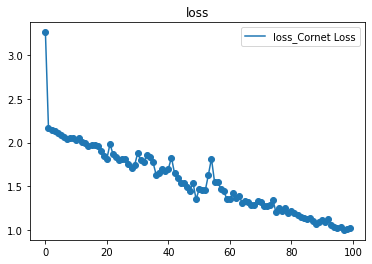

In [13]:
plotHistory(history,'Cornet Loss','loss')
# plotHistory(history,'Cornet Validation','val_loss')

In [14]:
train_raw.shape

(3120, 4002)

In [15]:
y_test=true
y_train=train_raw
#Predicting the testing sample 
StatList=[]
BPM_dir=BASE_DIR+'/Estimated_gen/'+trainname+'/'
if not os.path.exists(BPM_dir):
    os.mkdir(BPM_dir)
preds=gen_corenet.predict(y_train,514,1)
filename = BPM_dir+'/Est_'+change+'S'+trainname+'.mat'
scipy.io.savemat(filename,{"Estimate":preds,"TrueBPM":y_test})
# StatList.append(['Subject '+trainname,np.mean(np.absolute(PPG_true_test-preds)),np.std(np.absolute(PPG_true_test-preds))])

7/7 [==============================] - 21s 3s/step


In [16]:
#Calculating the overall MAE of the testing set
n=len(preds)
MAE=(1/n)*np.sum(np.abs(y_test-preds))
print(MAE)

0.9504625887674044


In [17]:
#Storing values for analysis
BIDMC=MAE
BIDMC_preds=preds
BIDMC_true=y_test

In [18]:
#Converting array to dataframe
data = {
    'preds': BIDMC_preds.flatten(),
    'true': BIDMC_true.flatten(),
}

bidmc = pd.DataFrame(data)

Text(0.5, 0, 'Window sample')

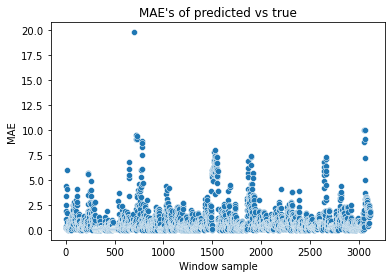

In [19]:
MAE_per_sample=np.abs(BIDMC_preds-BIDMC_true)
df2 = pd.DataFrame({'MAE':MAE_per_sample.flatten()})
sns.scatterplot(x=df2.index,y='MAE',data=df2)
plt.title("MAE's of predicted vs true")
plt.xlabel("Window sample")
# df.plot(kind='scatter', x='x1', y='columnA')


Text(0.5, 1.0, "Distribution of MAE's for the whole dataset")

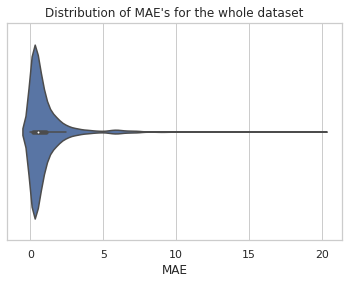

In [20]:
sns.set_theme(style="whitegrid")
# df2 = sns.load_dataset(df2)
sns.violinplot(x='MAE',data=df2)
plt.title("Distribution of MAE's for the whole dataset")

In [21]:
#Calculating mae for both datasets
mae_bidmc=mean_absolute_error(bidmc.true,bidmc.preds)
# mae_max=mean_absolute_error(maxrefds.true,maxrefds.preds)

std_bidmc=np.std(bidmc.true-bidmc.preds)
# std_maxrefds=np.std(maxrefds.true-maxrefds.preds)
                    
print("Mean absolute error and Standard Deviation for bidmc dataset is=", mae_bidmc,"+-",std_bidmc)
# print("Mean absolute error and Standard Deviation for maxrefds(our own) dataset is=", mae_max,"+-",std_maxrefds)

Mean absolute error and Standard Deviation for bidmc dataset is= 0.9504625887674044 +- 1.6543144340556333


In [24]:
with open('drive/My Drive/RAship/DL_preds_true.csv', 'w') as f:
  bidmc.to_csv(f)

In [ ]:
 ###EXTRA###